### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import PIL
import cv2

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import datetime
import os

import warnings
warnings.filterwarnings("ignore")



Ładowanie i wstępne przetwarzanie obrazów

In [2]:
img = cv2.imread(r"C:\Users\toawe\OneDrive\Pulpit\dl\archive (9)\images labeled\images labeled\disco\3_0.jpg")
type(img)

numpy.ndarray

In [3]:
print(img.shape,img.dtype)

(400, 400, 3) uint8


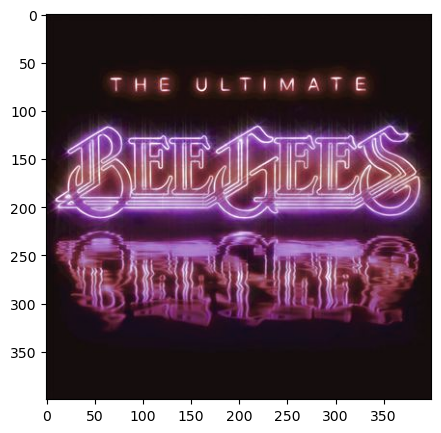

In [4]:
fig = plt.figure(figsize=(10,5))
plt.imshow(img)
plt.show()

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb#scrollTo=gIjgz7_JIo_m

In [5]:
path = r"C:\Users\toawe\OneDrive\Pulpit\dl\archive (9)\images labeled\images labeled" #path to the folders with data on disc

In [43]:
categories = ['disco', 'electro', 'folk', 'rap', 'rock']

def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fr'C:\Users\toawe\OneDrive\Pulpit\dl\archive (9)\images labeled\images labeled\{category}'): #path to the folders with data
            img = cv2.imread(fr'C:\Users\toawe\OneDrive\Pulpit\dl\archive (9)\images labeled\images labeled\{category}/{image_name}') #path to the folders
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_array = cv2.resize(img, (224,224))
            img_lst.append(img_array)
            labels.append(index)
    return img_lst, labels

img_lst, labels = load_images_and_labels(categories)

In [44]:
len(img_lst)

9311

In [45]:
len(labels)

9311

In [57]:
img_lst = np.array(img_lst).astype(np.float16)
labels = np.array(labels).astype(np.float16)

In [58]:
x_train, x_test, y_train, y_test = train_test_split(img_lst, labels, test_size=0.1, random_state=42) #random state zmieniec

x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.astype(np.float16)  #astype jeszcze raz chyba juz nie bedzie potrzebne, ale nie zmieniałam
x_test = x_test.astype(np.float16)

In [60]:
print(f'Ilość zdjęć dla zbioru treningowego: {x_train.shape[0]}')
print(f'Ilość zdjęć dla zbioru testowego: {x_test.shape[0]}')

Ilość zdjęć dla zbioru treningowego: 8379
Ilość zdjęć dla zbioru testowego: 932


In [61]:
y_train

array([2., 0., 1., ..., 2., 0., 3.], dtype=float16)

In [62]:
# transformujemy y_train
y_train = OneHotEncoder().fit_transform(y_train.reshape(-1,1)).toarray()
# podglądamy
y_train = y_train.astype(np.float32)
y_train

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [63]:
y_test[:5]

array([4., 0., 1., 2., 1.], dtype=float16)

In [64]:
# transformujemy y_test
y_test = OneHotEncoder().fit_transform(y_test.reshape(-1,1)).toarray()
# podglądamy
y_test = y_test.astype(np.float32)
y_test

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [65]:
print("y_test.shape: ", y_test.shape)
print("y_train.shape: ", y_train.shape)

y_test.shape:  (932, 5)
y_train.shape:  (8379, 5)


In [66]:
# sprawdzamy ilość wejściowych obrazow i ich shape
print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)

x_train shape:  (8379, 224, 224, 3)
x_test shape:  (932, 224, 224, 3)


In [67]:
x_train.shape

(8379, 224, 224, 3)

In [68]:
class_names = ['disco', 'electro', 'folk', 'rap', 'rock']
num_classes = len(class_names)

In [69]:
def create_cnn_model(inShape, convNum, hNum, hAct, outNum, loss):
    """
    :param inShape: kształt wejścia, h*w*c
    :param convNum: lista ilości featerów w warstwach konwolucyjnych
    :param hNum: lista ilości neuronów w poszczególnych warstwach ukrytych
    :param hAct: rodzaj aktywacji w warstwach ukrytych, str
    :param outNum: ilość
    :param loss: funkcja kosztu
    """
    # pusty model
    model = tf.keras.Sequential()
    # warstwa wejściowa
    model.add(layers.InputLayer(input_shape=(inShape)))
    # warstwy konwolucyjne
    for idx, oneConvNum in enumerate(convNum):
        # dodajemy kolejną warstwę konwolucyjną
        # zmienia nam ilość cech(kanałów) na oneConvNum
        model.add(layers.Conv2D(
                                    filters=oneConvNum,
                                    kernel_size=3,
                                    strides=1,
                                    padding="SAME",
                                    activation="relu"
                                    )
                                )
        # doajemy następującego po convie maxpool'a
        # zmniejsza nam wymiarowość HxW o połowę
        model.add(layers.MaxPool2D(
                                    pool_size=(2, 2),
                                    strides=2,
                                    padding="SAME"
                                    )
                                )
    # spłaszczamy po konwolucjach, przygotowanie pod relu
    model.add(layers.Flatten())
    # warstwy fully connected
    for idx, oneHidNum in enumerate(hNum):
        # dodajemy warstwę
        model.add(layers.Dense(oneHidNum, activation=hAct))
    # warstwa wyjściowa
    model.add(layers.Dense(outNum))
    # warstwa softmax, dystrybucja prawdopodobieństwa
    model.add(layers.Softmax())
    print(model.summary())
    
    opt = tf.keras.optimizers.Adam()
    
    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=["accuracy"]
    )
    
    return model

In [22]:
model_a = create_cnn_model(
    inShape=x_train.shape[1:],
    convNum=[16,32],
    hNum=[200],
    hAct="relu",
    outNum=num_classes,
    loss=tf.keras.losses.CategoricalCrossentropy()
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 64800)             0         
                                                                 
 dense (Dense)               (None, 200)               1

In [23]:
# dodajemy zapisywanie logów do tensorboard'a
log_dir = "logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [24]:
history = model_a.fit(
    x=x_train,
    y=y_train,
    batch_size=200,
    epochs=10,
    validation_split=0.05,
    callbacks=[tensorboard_callback]
)

Epoch 1/10
40/40 [==============================] - 71s 2s/step - loss: 3.3077 - accuracy: 0.2260 - val_loss: 1.6068 - val_accuracy: 0.2434
Epoch 2/10
40/40 [==============================] - 69s 2s/step - loss: 1.5824 - accuracy: 0.2790 - val_loss: 1.5274 - val_accuracy: 0.3556
Epoch 3/10
40/40 [==============================] - 67s 2s/step - loss: 1.4660 - accuracy: 0.3817 - val_loss: 1.4335 - val_accuracy: 0.4296
Epoch 4/10
40/40 [==============================] - 68s 2s/step - loss: 1.2915 - accuracy: 0.4910 - val_loss: 1.4023 - val_accuracy: 0.4296
Epoch 5/10
40/40 [==============================] - 61s 1s/step - loss: 1.0785 - accuracy: 0.5984 - val_loss: 1.4985 - val_accuracy: 0.3962
Epoch 6/10
40/40 [==============================] - 65s 2s/step - loss: 0.8527 - accuracy: 0.6987 - val_loss: 1.5437 - val_accuracy: 0.4105
Epoch 7/10
40/40 [==============================] - 63s 1s/step - loss: 0.6107 - accuracy: 0.8000 - val_loss: 1.6987 - val_accuracy: 0.4105
Epoch 8/10
40/40 [==

In [25]:
# jakie wartości przechowuje historia wyników
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

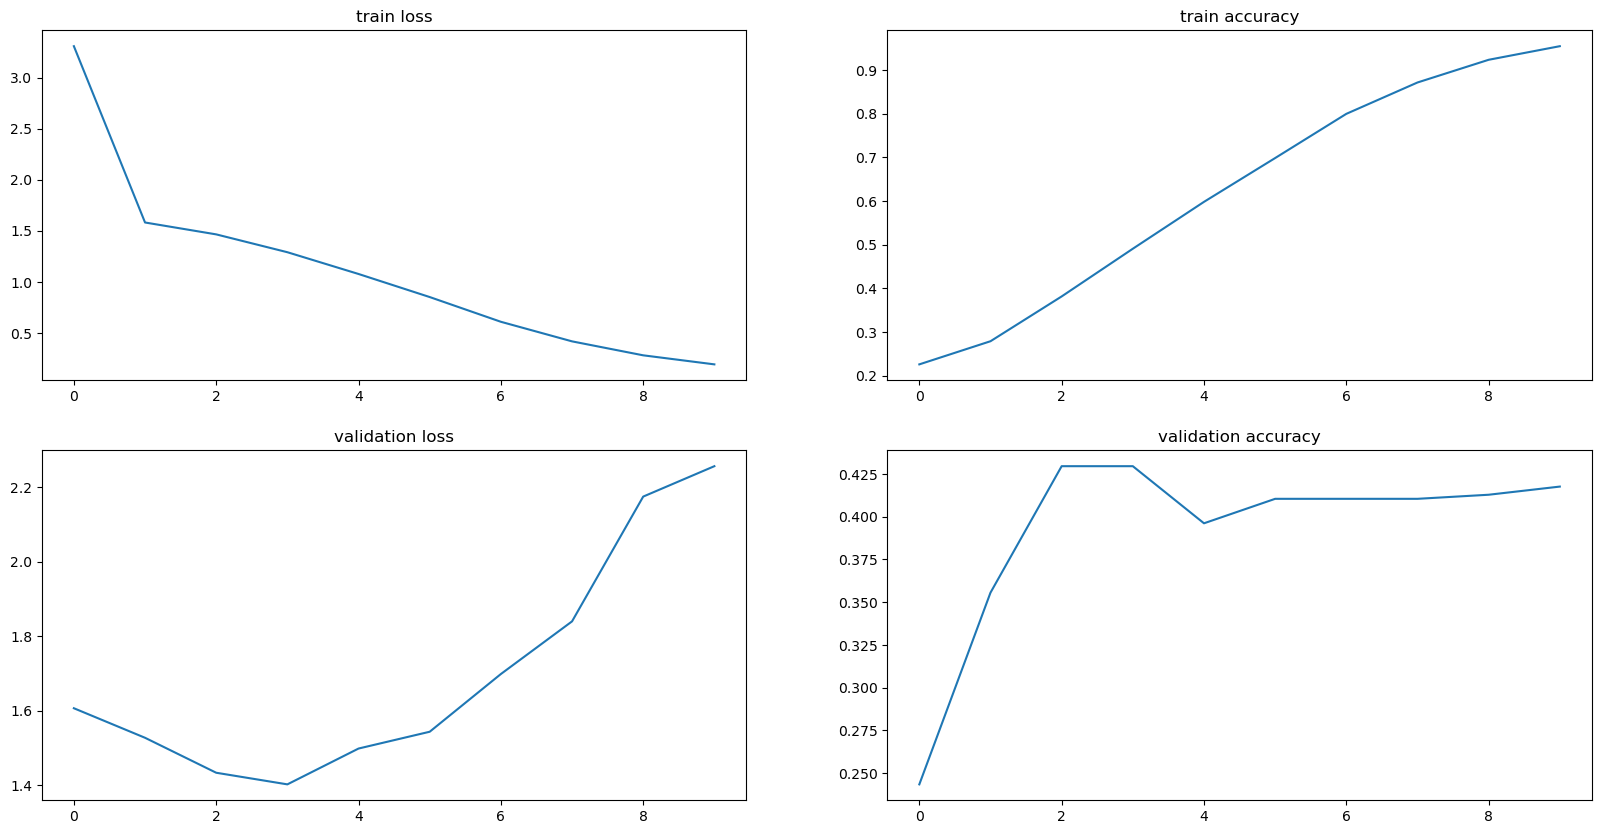

30/30 [==============================] - 3s 53ms/step
              precision    recall  f1-score   support

           0       0.49      0.37      0.42       190
           1       0.43      0.52      0.47       184
           2       0.35      0.39      0.37       179
           3       0.59      0.52      0.56       193
           4       0.32      0.35      0.34       186

    accuracy                           0.43       932
   macro avg       0.44      0.43      0.43       932
weighted avg       0.44      0.43      0.43       932



In [26]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))
# wyświetlamy wykresy
ax[0][0].plot(history.history["loss"])
ax[0][1].plot(history.history["accuracy"])
ax[1][0].plot(history.history["val_loss"])
ax[1][1].plot(history.history["val_accuracy"])
#nazywamy zdjęcia
ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

# testowanie
y_pred = model_a.predict(x_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

In [26]:
##podejrzenie widoku tensorboard'a
%load_ext tensorboard
%tensorboard --logdir "logs"

# Transfer Learning

In [27]:
batch_size = 32
img_height = 224
img_width = 224

data_dir=r"C:\Users\toawe\OneDrive\Pulpit\dl\archive (9)\images labeled\images labeled" 
# path to the folders with data on my drive


train_ds= tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=100, #losowanie zmieniec
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=100,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9311 files belonging to 5 classes.
Using 8380 files for training.
Found 9311 files belonging to 5 classes.
Using 931 files for validation.


In [28]:
class_names = train_ds.class_names # in this method labels are generated from the directory structure
print(class_names)
print(len(class_names))

['disco', 'electro', 'folk', 'rap', 'rock']
5


In [29]:
num_classes = len(class_names)

In [30]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [31]:
image_batch.shape

TensorShape([32, 224, 224, 3])

In [32]:
labels_batch.shape

TensorShape([32])

In [33]:
normalization_layer = layers.Rescaling(1./255)

In [34]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99943495


In [35]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Visualize the data

Here are the first 12 images from the training dataset AND from the validation dataset:

In [73]:
def visualize():
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    
    plt.figure(figsize=(10, 10))
    for images, labels in val_ds.take(1):
        for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

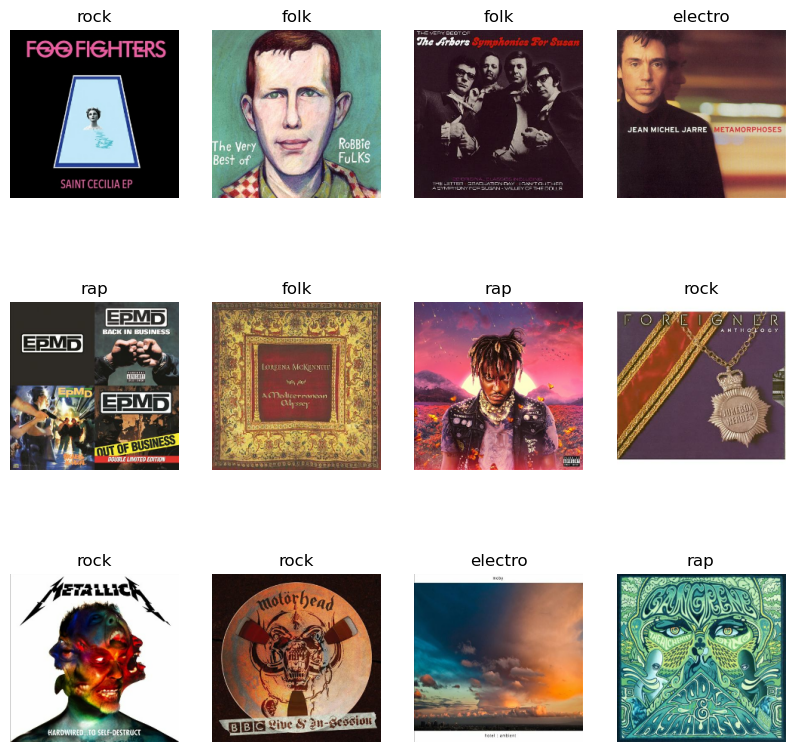

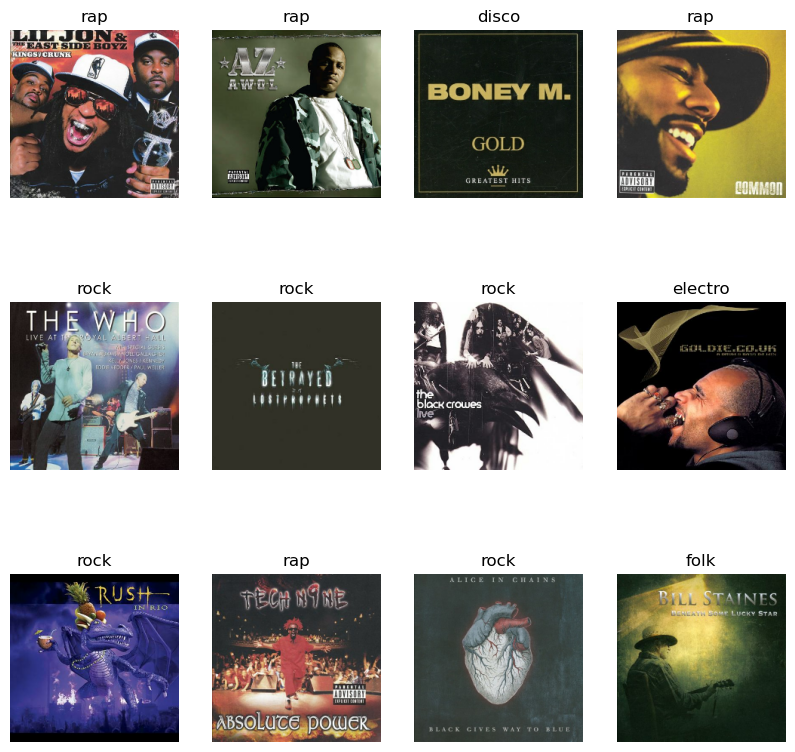

In [74]:
visualize()

# EfficientNetB1

In [37]:
# wejście
batch_size = 64
input_shape = (224,224,3)
inputLayer = tf.keras.Input(shape=(input_shape))

In [38]:
# bierzemy wytrenowany wcześniej model
base_model_1 = tf.keras.applications.efficientnet.EfficientNetB1(
    #alpha=1.0,
    weights='imagenet',  # wczytaj z nauczonymi wagami
    input_shape=input_shape,
    include_top=False)   # nie dołączaj ostatniej warstwy klasyfikatora, sami swoją dodamy

# nie chcemy aby nauczony już feature extractor się uczył
base_model_1.trainable = False

# dodajemy ostatnie warstwy klasyfikatora
x = base_model_1(inputLayer, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation='relu')(x) # dodatkowa warstwa
output = layers.Dense(num_classes, activation="softmax")(x)


# zamykamy w kerasowy model
model_1 = tf.keras.Model(inputLayer, output)
model_1.summary()

# kompilujemy całość
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),#zmienieniony lr
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 7, 7, 1280)       6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 5)                 5125      
                                                             

In [40]:
%%time

history = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

# przy większej ilości epok accuracy i tak nie rośnie

Epoch 1/5
262/262 [==============================] - 280s 1s/step - loss: 0.6536 - accuracy: 0.7846 - val_loss: 1.0994 - val_accuracy: 0.5800
Epoch 2/5
262/262 [==============================] - 301s 1s/step - loss: 0.6221 - accuracy: 0.7974 - val_loss: 1.0998 - val_accuracy: 0.5875
Epoch 3/5
262/262 [==============================] - 300s 1s/step - loss: 0.5832 - accuracy: 0.8162 - val_loss: 1.1009 - val_accuracy: 0.5865
Epoch 4/5
262/262 [==============================] - 303s 1s/step - loss: 0.5464 - accuracy: 0.8296 - val_loss: 1.1016 - val_accuracy: 0.5832
Epoch 5/5
262/262 [==============================] - 305s 1s/step - loss: 0.5110 - accuracy: 0.8489 - val_loss: 1.1078 - val_accuracy: 0.5929
Wall time: 24min 48s


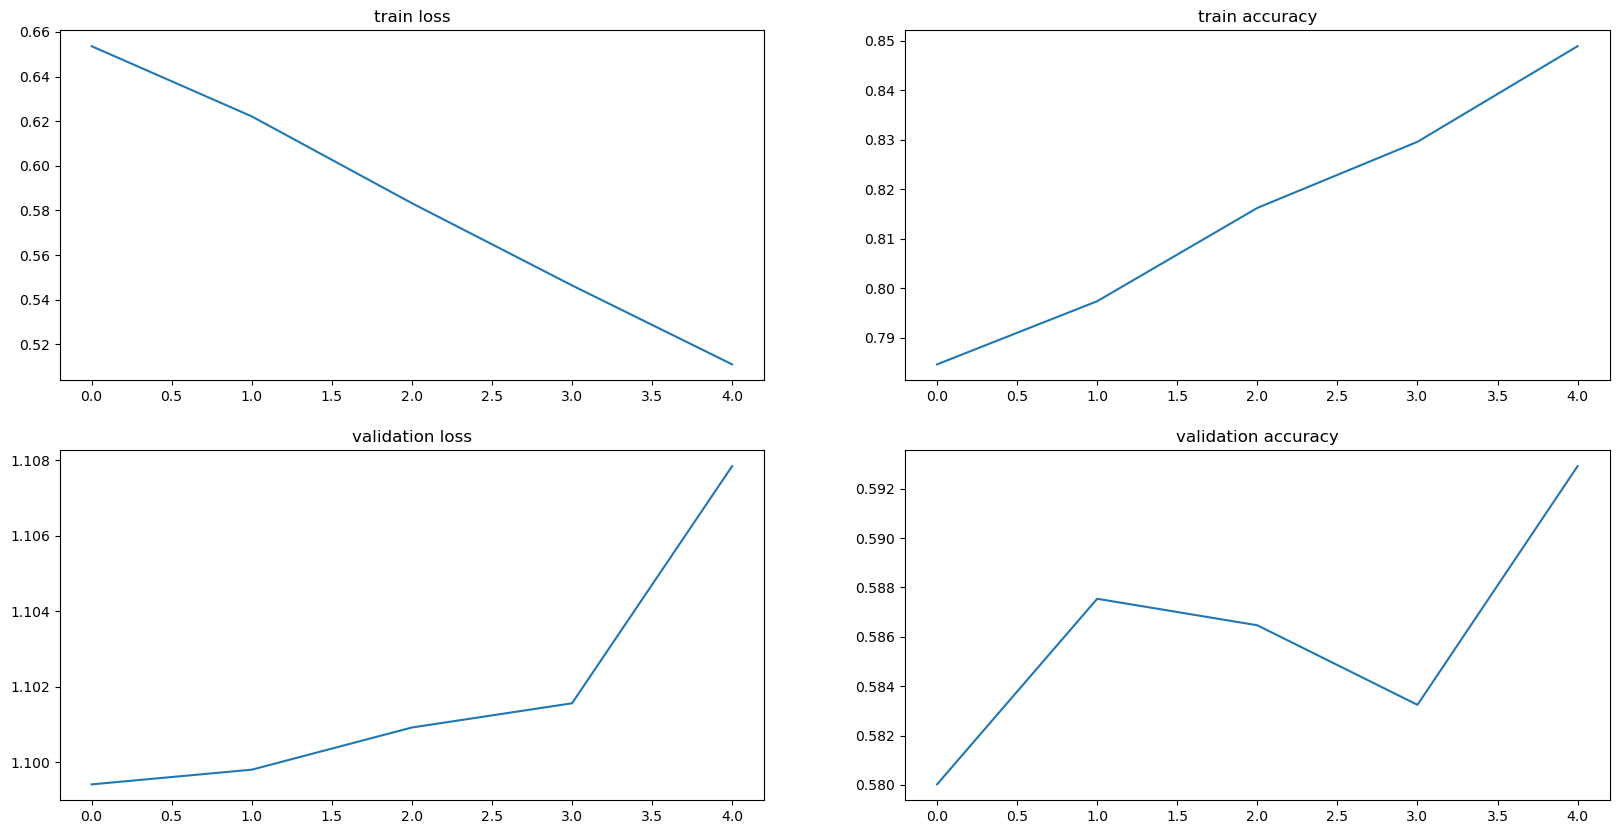

In [41]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))
# wyświetlamy wykresy
ax[0][0].plot(history.history["loss"])
ax[0][1].plot(history.history["accuracy"])
ax[1][0].plot(history.history["val_loss"])
ax[1][1].plot(history.history["val_accuracy"])
#nazywamy zdjęcia
ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

In [72]:
# testowanie ???????????????????????????
y_pred = model_1.predict(x_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

30/30 [==============================] - 30s 977ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       190
           1       0.20      1.00      0.33       184
           2       0.00      0.00      0.00       179
           3       0.00      0.00      0.00       193
           4       0.00      0.00      0.00       186

    accuracy                           0.20       932
   macro avg       0.04      0.20      0.07       932
weighted avg       0.04      0.20      0.07       932



In [71]:
#zapisanie modelu 
import joblib
joblib.dump(model_1,'model_1.sav')

INFO:tensorflow:Assets written to: ram://f3056745-f37c-467a-878a-da159d982da2/assets


INFO:tensorflow:Assets written to: ram://f3056745-f37c-467a-878a-da159d982da2/assets


['model_1.sav']